In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [3]:
import pandas as pd

In [17]:
data=pd.read_csv('D:\DeTaiNam2024\SoLieu\KinhTeViMo\GDP.csv')

In [18]:
data.head()

,t,GDP_VN
0,1984,3.436346e+10
1,1985,3.567129e+10
2,1986,3.666626e+10
3,1987,3.798019e+10
4,1988,3.993047e+10


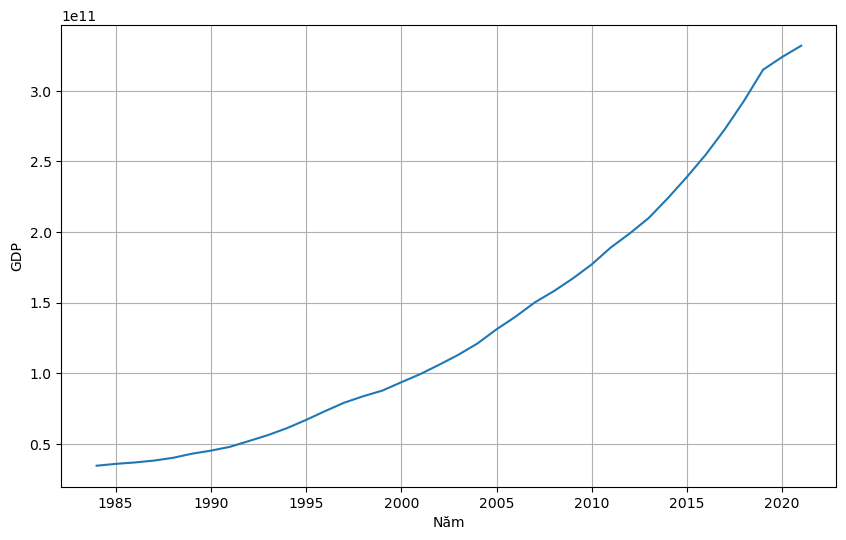

In [19]:
# Initialize lists
time_step = []
close = []

# Open CSV file
with open('D:\DeTaiNam2024\SoLieu\KinhTeViMo\GDP.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    close.append(float(row[1]))

# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(close)

# Preview the data
plot_series(time, series, xlabel='Năm', ylabel='GDP')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Đọc dữ liệu CPI
data = pd.read_csv('D:\DeTaiNam2024\SoLieu\KinhTeViMo\GDP.csv')  # Thay 'path_to_cpi_data.csv' bằng đường dẫn của bạn
data = data['GDP_VN'].values  # Giả sử cột CPI chứa chỉ số cần dự báo
data = data.reshape(-1, 1)

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Tạo chuỗi thời gian
sequence_length = 12  # Ví dụ dùng 12 tháng để dự báo tháng tiếp theo
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i, 0])
    y.append(data_scaled[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Chia tập huấn luyện và kiểm tra
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import LSTMCell, RNN

class sLSTMCell(LSTMCell):
    def __init__(self, units, **kwargs):
        super(sLSTMCell, self).__init__(units, **kwargs)
    
    def call(self, inputs, states, training=None):
        # Gọi hàm LSTM mặc định
        h, [c, h] = super(sLSTMCell, self).call(inputs, states, training=training)
        
        # Tùy chỉnh cổng quên và cổng đầu vào
        forget_gate = tf.math.exp(c)  # Sử dụng hàm mũ e cho cổng quên
        input_gate = tf.math.exp(2 * c)  # Sử dụng hàm mũ cơ số 2 cho cổng đầu vào
        
        # Áp dụng các cổng vào trạng thái bộ nhớ
        new_c = forget_gate * c + input_gate * h
        
        # Trả về trạng thái cập nhật và output
        return h, [new_c, h]

# Tạo lớp RNN với sLSTMCell
def build_sLSTM_model(input_shape, units=50):
    inputs = tf.keras.Input(shape=input_shape)
    sLSTM_layer = RNN(sLSTMCell(units))(inputs)
    output = tf.keras.layers.Dense(1)(sLSTM_layer)
    
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Xây dựng mô hình sLSTM
model = build_sLSTM_model((X_train.shape[1], 1))
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 rnn (RNN)                   (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [3]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/50
2/2 [==============================] - 3s 426ms/step - loss: 0.0231 - val_loss: 0.1673
Epoch 2/50
2/2 [==============================] - 0s 42ms/step - loss: 0.0136 - val_loss: 0.0840
Epoch 3/50
2/2 [==============================] - 0s 54ms/step - loss: 0.0057 - val_loss: 0.0071
Epoch 4/50
2/2 [==============================] - 0s 52ms/step - loss: 8.4843e-04 - val_loss: 0.0023
Epoch 5/50
2/2 [==============================] - 0s 49ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 6/50
2/2 [==============================] - 0s 55ms/step - loss: 0.0021 - val_loss: 8.8844e-04
Epoch 7/50
2/2 [==============================] - 0s 58ms/step - loss: 4.4676e-04 - val_loss: 0.0027
Epoch 8/50
2/2 [==============================] - 0s 48ms/step - loss: 2.1396e-04 - val_loss: 0.0054
Epoch 9/50
2/2 [==============================] - 0s 57ms/step - loss: 7.7551e-04 - val_loss: 0.0028
Epoch 10/50
2/2 [==============================] - 0s 60ms/step - loss: 4.8710e-04 - val_loss: 6.0850e-04


1/1 [==============================] - 0s 32ms/step
Mean Squared Error (MSE): 4.659294689560013e+19
Mean Absolute Error (MAE): 5501226325.333333
Root Mean Squared Error (RMSE): 6825902643.284633


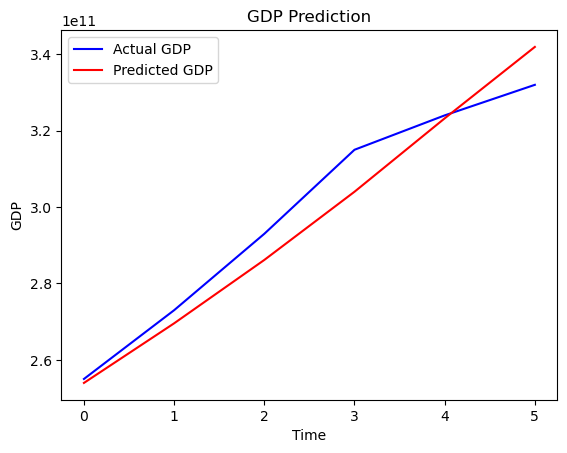

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Dự đoán trên tập kiểm tra
predicted_cpi = model.predict(X_test)

# Chuyển đổi giá trị dự đoán về dạng CPI ban đầu
predicted_cpi = scaler.inverse_transform(predicted_cpi)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính toán các chỉ số đánh giá
mse = mean_squared_error(y_test_actual, predicted_cpi)
mae = mean_absolute_error(y_test_actual, predicted_cpi)
rmse = np.sqrt(mse)

# In kết quả
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

# Vẽ biểu đồ dự đoán và giá trị thực tế
plt.plot(y_test_actual, color='blue', label='Actual GDP')
plt.plot(predicted_cpi, color='red', label='Predicted GDP')
plt.title('GDP Prediction')
plt.xlabel('Time')
plt.ylabel('GDP')
plt.legend()
plt.show()


In [5]:
mse1=np.mean(np.square(y_test_actual - predicted_cpi))
print('MSE=', mse1)
mean_error_percent1 = np.mean(np.abs((predicted_cpi - y_test_actual) / y_test_actual))
accuracy1 = 1 - mean_error_percent1
print('Accuracy=', accuracy1)
print('mean_error_percent=', mean_error_percent1)

MSE= 4.659294689560013e+19
Accuracy= 0.9821356196913508
mean_error_percent= 0.017864380308649255
